In [144]:
# !conda install -c conda-forge gmaps -y
# !jupyter nbextension enable --py gmaps
# with open('api_key.txt') as f:
#     api_key = f.readline()
#     f.close
# import gmaps
# gmaps.configure(api_key=api_key)
import pandas as pd
import numpy as np
import networkx as nx
import osmnx as ox
import geopandas as gpd
import contextily as cx

%matplotlib inline
ox.__version__

'1.2.2'

In [26]:
# place = {"city": "Berkeley", "state": "California", "country": "USA"}
# G = ox.graph_from_place(place, network_type="drive")

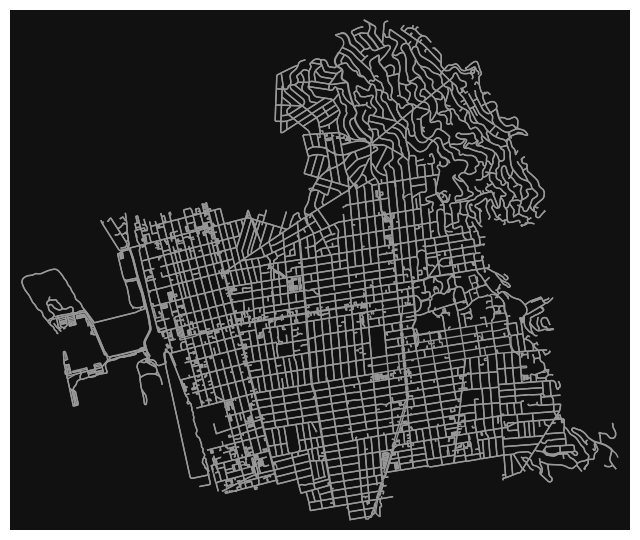

In [27]:
# fig, ax = ox.plot_graph(G, node_size=0, dpi=600)

(79, 51)


In [85]:
pois = gdf.to_crs('+proj=cea').centroid.to_crs(gdf.crs)
X = pois.x
Y = pois.y
#nn = ox.nearest_nodes(G, X, Y)

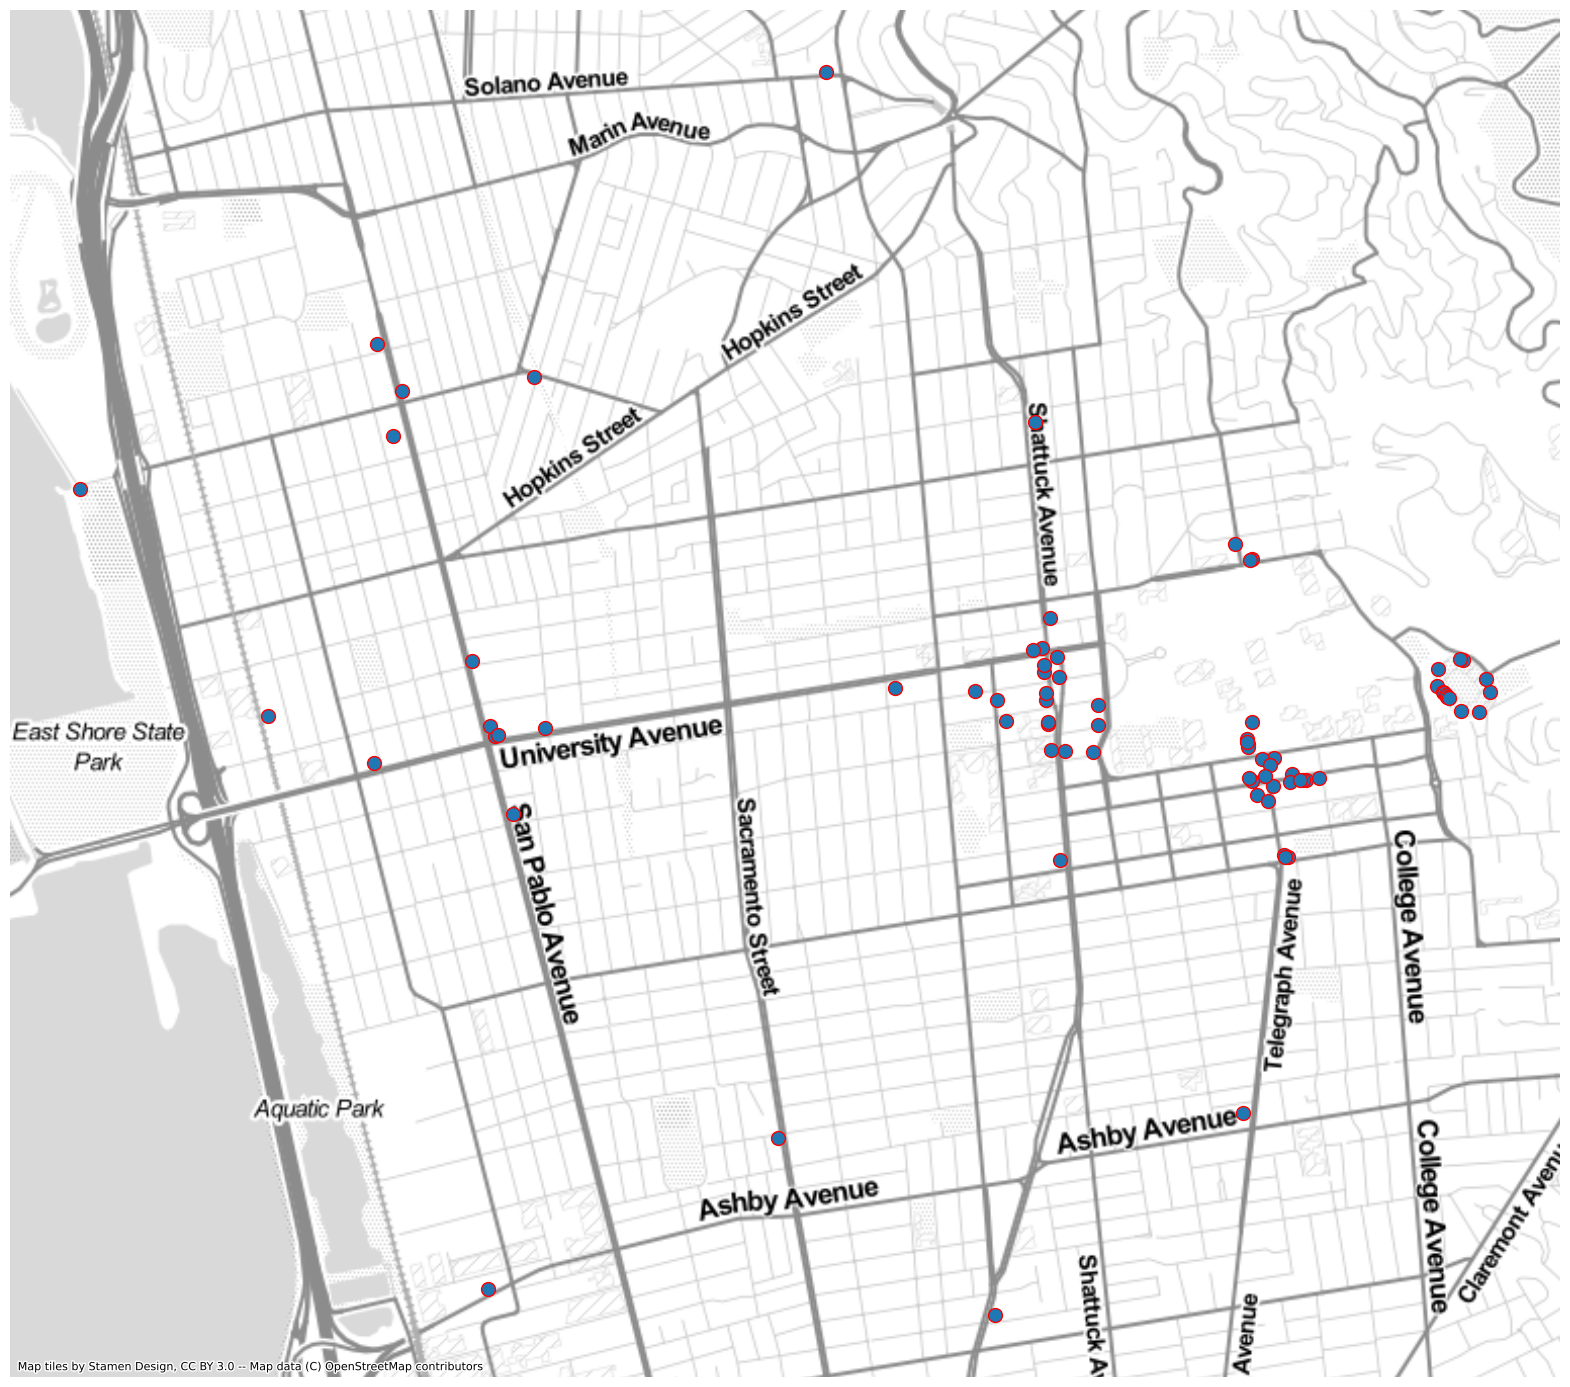

In [102]:
ax = pois.to_crs(epsg=3857).plot(figsize=(20,20), alpha=1, markersize=100, edgecolor='red')
cx.add_basemap(ax, source=cx.providers.Stamen.TonerLite)
ax.set_axis_off()

# Google Maps Route

In [103]:
!jupyter nbextension enable --py gmaps
with open('api_key.txt') as f:
    api_key = f.readline()
    f.close
import gmaps
gmaps.configure(api_key=api_key)
import googlemaps
from datetime import datetime
gmaps = googlemaps.Client(key=api_key)

Enabling notebook extension jupyter-gmaps/extension...
      - Validating: OK


In [358]:
tags = {"amenity": "fast_food"}
# tags = {"shop": "supermarket"}
# tags = {"highway": "bus_stop"}

gdf = ox.geometries_from_place(place, tags)
# fig, ax = ox.plot_footprints(gdf, figsize=(3, 3))

In [359]:
gdf

addr:city addr:postcode        addr:street alt_name  \
element_type osmid                                                             
node         286632462    Berkeley         94704       Bancroft Way    Jamba   
             288991105    Berkeley         94703  University Avenue      NaN   
             314115417         NaN           NaN                NaN      NaN   
             314115730    Berkeley         94704    Shattuck Avenue      NaN   
             318886210         NaN           NaN      Hearst Avenue      NaN   
...                            ...           ...                ...      ...   
             9501233308        NaN           NaN                NaN      NaN   
             9553418873   Berkeley           NaN      Durant Avenue      NaN   
             9572013607        NaN           NaN                NaN      NaN   
             10018909585       NaN           NaN                NaN      NaN   
way          43313850          NaN           NaN  University Avenue      NaN   

                            amenity        brand brand:wikidata  \
element_type osmid                                                
node         286632462    fast_food        Jamba       Q3088784   
             288991105    fast_food          NaN            NaN   
             314115417    fast_food          NaN            NaN   
             314115730    fast_food   McDonald's         Q38076   
             318886210    fast_food       Subway        Q244457   
...                             ...          ...            ...   
             9501233308   fast_food          NaN            NaN   
             9553418873   fast_food    Taco Bell        Q752941   
             9572013607   fast_food          NaN            NaN   
             10018909585  fast_food  Burger King        Q177054   
way          43313850     fast_food          NaN            NaN   

                                 brand:wikipedia     cuisine  \
element_type osmid                                             
node         286632462            en:Jamba Juice       juice   
             288991105                       NaN      burger   
             314115417                       NaN     mexican   
             314115730             en:McDonald's      burger   
             318886210    en:Subway (restaurant)    sandwich   
...                                          ...         ...   
             9501233308                      NaN         NaN   
             9553418873             en:Taco Bell     tex-mex   
             9572013607                      NaN  bubble_tea   
             10018909585                     NaN      burger   
way          43313850                        NaN         NaN   

                                               name  ... contact:instagram  \
element_type osmid                                   ...                     
node         286632462                  Jamba Juice  ...               NaN   
             288991105    Nation's Giant Hamburgers  ...               NaN   
             314115417            Mexicana Taqueria  ...               NaN   
             314115730                   McDonald's  ...               NaN   
             318886210                       Subway  ...               NaN   
...                                             ...  ...               ...   
             9501233308         Taqueria food truck  ...               NaN   
             9553418873           Taco Bell Cantina  ...               NaN   
             9572013607               Take.Eat.Easy  ...               NaN   
             10018909585                Burger King  ...               NaN   
way          43313850               Foster's Freeze  ...               NaN   

                         contact:yelp email note opening_hours:url  \
element_type osmid                                                   
node         286632462            NaN   NaN  NaN               NaN   
             288991105            NaN   NaN  NaN      

In [324]:
# To-do: Augment the neighborhoods list.
neighborhoods = [(37.863684902759836, -122.26634794235939), #2121 Blake St
                ]

pois_per_neighborhood = [0]*len(neighborhoods)
for n in range(len(neighborhoods)):
    pois_per_neighborhood[n] = ox.geometries.geometries_from_point(neighborhoods[n], tags, dist=5*1609) # 5 miles
    pois_per_neighborhood[n].reset_index(inplace=True)

In [ ]:
def only_keep_points(gdf):
    return gdf[gdf['element_type']=='node']

def dirs_from_nbhd_to_poi(nbhd, pois, mode="transit", departure_time=datetime.now()):
    """
    Returns the distances and durations FROM the provided point location TO all the POIs in pois.
    """
    directions_results = [0]*len(pois)
    distances = [0]*len(pois)
    durations = [0]*len(pois)
    for i in range(len(pois)):
            directions_results[i] = gmaps.directions(origin=nbhd,
                                                     destination=(pois.iloc[i]['geometry'].y, pois.iloc[i]['geometry'].x), # lat, lon
                                                     mode="transit", # "driving", "walking", "bicycling" or "transit"
                                                     departure_time=departure_time
                                                       )
            distances[i] = directions_results[i][0]['legs'][0]['distance']['value']
            durations[i] = directions_results[i][0]['legs'][0]['duration']['value']
    return distances, durations

In [ ]:
for n in range(len(neighborhoods)):
    pois_per_neighborhood[n] = only_keep_points(pois_per_neighborhood[n])
    distances[n], durations[n] = dirs_from_nbhd_to_poi(neighborhoods[n], 
                                             pois_per_neighborhood[n], 
                                             "transit", 
                                             datetime.now())

In [348]:
for n in range(len(neighborhoods)):
    dist_dur[n] = gpd.GeoDataFrame(data={"element_type": pois_per_neighborhood[n]['element_type'], 
                                         "osmid": pois_per_neighborhood[n]['osmid'], 
                                         "distance (m)": distances[n], 
                                         "duration (s)": durations[n]
                                        }, 
                                   geometry=pois_per_neighborhood[n].geometry
                                  )

In [357]:
dist_dur[0]

,element_type,osmid,distance (m),duration (s),geometry
0,node,286632462,1359,592,POINT (-122.25877 37.86861)
1,node,288991105,1788,954,POINT (-122.27484 37.87095)
2,node,314115417,2000,750,POINT (-122.26892 37.87987)
3,node,314115730,1129,471,POINT (-122.26863 37.87230)
4,node,318886210,2001,1026,POINT (-122.25968 37.87528)
...,...,...,...,...,...
173,node,9572013607,1127,490,POINT (-122.25982 37.86796)
174,node,9583500381,2507,862,POINT (-122.26118 37.84709)
175,node,9583500382,2507,862,POINT (-122.26116 37.84703)
176,node,9721421803,7397,1692,POINT (-122.26546 37.80797)
